# Lab | Variational Autoencoder (VAE) on Fashion-MNIST Dataset

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model, datasets
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers and backend
###
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds

Training data shape: (60000, 784)
Test data shape: (10000, 784)


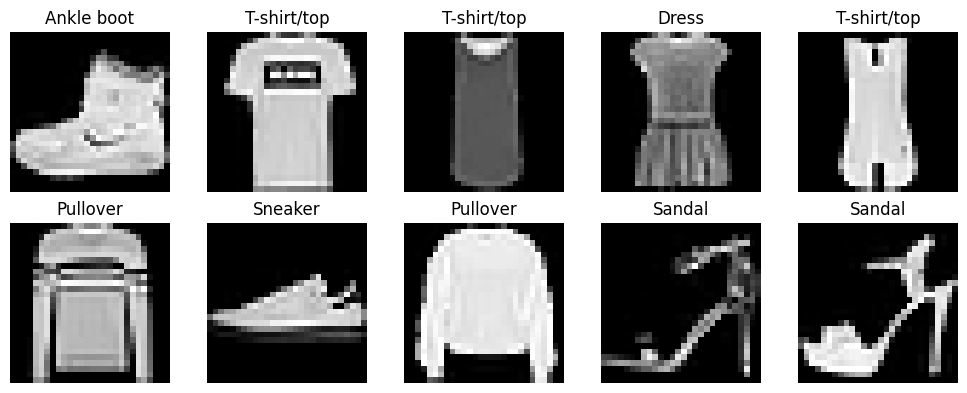

In [2]:
# Load and preprocess Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to flatten the images
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display some sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Sampling layer for the VAE
#TODO: YOUR CODE HERE

def preprocess(features):
    # Normalize images to [0, 1]
    image = tf.cast(features['image'], tf.float32) / 255.0
    return image

# Load CIFAR-10 data
(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist', split=['train', 'test'], shuffle_files=True,
    as_supervised=False, with_info=True, batch_size=128)
ds_train = ds_train.map(preprocess)
ds_test = ds_test.map(preprocess)


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, using TensorFlow functions."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim), mean=0.0, stddev=1.0, seed=42)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [10]:
# Build the encoder
latent_dim = 2  # 2D latent space for easy visualization
original_dim = 28 * 28
#TODO: YOUR CODE HERE

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 14, 14, 64)           640       ['input_3[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 7, 7, 128)            73856     ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 4, 4, 256)            295168    ['conv2d_7[0][0]']            
                                                                                            

In [11]:
# Build the decoder
# Create the decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# Print the summary of the decoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 256)       590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         1153

In [12]:
# Build the VAE model
#TODO: YOUR CODE HERE
class VAE(keras.Model):
    # Initialize the Variational Autoencoder (VAE)
    def __init__(self, encoder, decoder, beta=0.5, **kwargs):
        super().__init__(**kwargs)
        # Encoder: compresses input data into a latent space
        self.encoder = encoder
        # Decoder: reconstructs input data from the latent space
        self.decoder = decoder
        # Beta: scaling factor for the KL divergence term
        self.beta = beta
        # Metrics to track the total loss during training
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        # Metrics to track the reconstruction loss during training
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        # Metrics to track the KL divergence loss during training
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # Custom property to return compiled metrics at the end of model training
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Custom training step for the model, called on each batch of data
    def train_step(self, data):
        # GradientTape to record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # Encode the input data and retrieve the mean, log variance, and sampled latent vector
            z_mean, z_log_var, z = self.encoder(data)
            # Decode the sampled latent vector to reconstruct the input data
            reconstruction = self.decoder(z)
            # Calculate the mean squared reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # Calculate the KL divergence loss, scaled by beta
            kl_loss = -0.5 * self.beta * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            # Total loss is the sum of reconstruction loss and KL divergence loss
            total_loss = reconstruction_loss + kl_loss
        # Compute gradients of the total loss with respect to the weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Apply gradients to variables to minimize the total loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update state of the loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return the current loss metrics to monitor during training
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [17]:
# Train the VAE
#TODO: YOUR CODE HERE
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005))
vae.fit(ds_train, epochs=30, batch_size=512)

Epoch 1/30
469/469 [==============================] - 209s 445ms/step - loss: 251.0120 - reconstruction_loss: 248.6489 - kl_loss: 2.1429
Epoch 2/30
469/469 [==============================] - 213s 454ms/step - loss: 249.9549 - reconstruction_loss: 247.8172 - kl_loss: 2.1466
Epoch 3/30
469/469 [==============================] - 230s 490ms/step - loss: 249.6140 - reconstruction_loss: 247.4339 - kl_loss: 2.1447
Epoch 4/30
469/469 [==============================] - 229s 489ms/step - loss: 249.0070 - reconstruction_loss: 246.9462 - kl_loss: 2.1521
Epoch 5/30
469/469 [==============================] - 217s 462ms/step - loss: 248.7225 - reconstruction_loss: 246.8043 - kl_loss: 2.1531
Epoch 6/30
469/469 [==============================] - 222s 473ms/step - loss: 248.4343 - reconstruction_loss: 246.4066 - kl_loss: 2.1584
Epoch 7/30
469/469 [==============================] - 235s 500ms/step - loss: 248.0840 - reconstruction_loss: 246.0246 - kl_loss: 2.1551
Epoch 8/30
469/469 [=====================

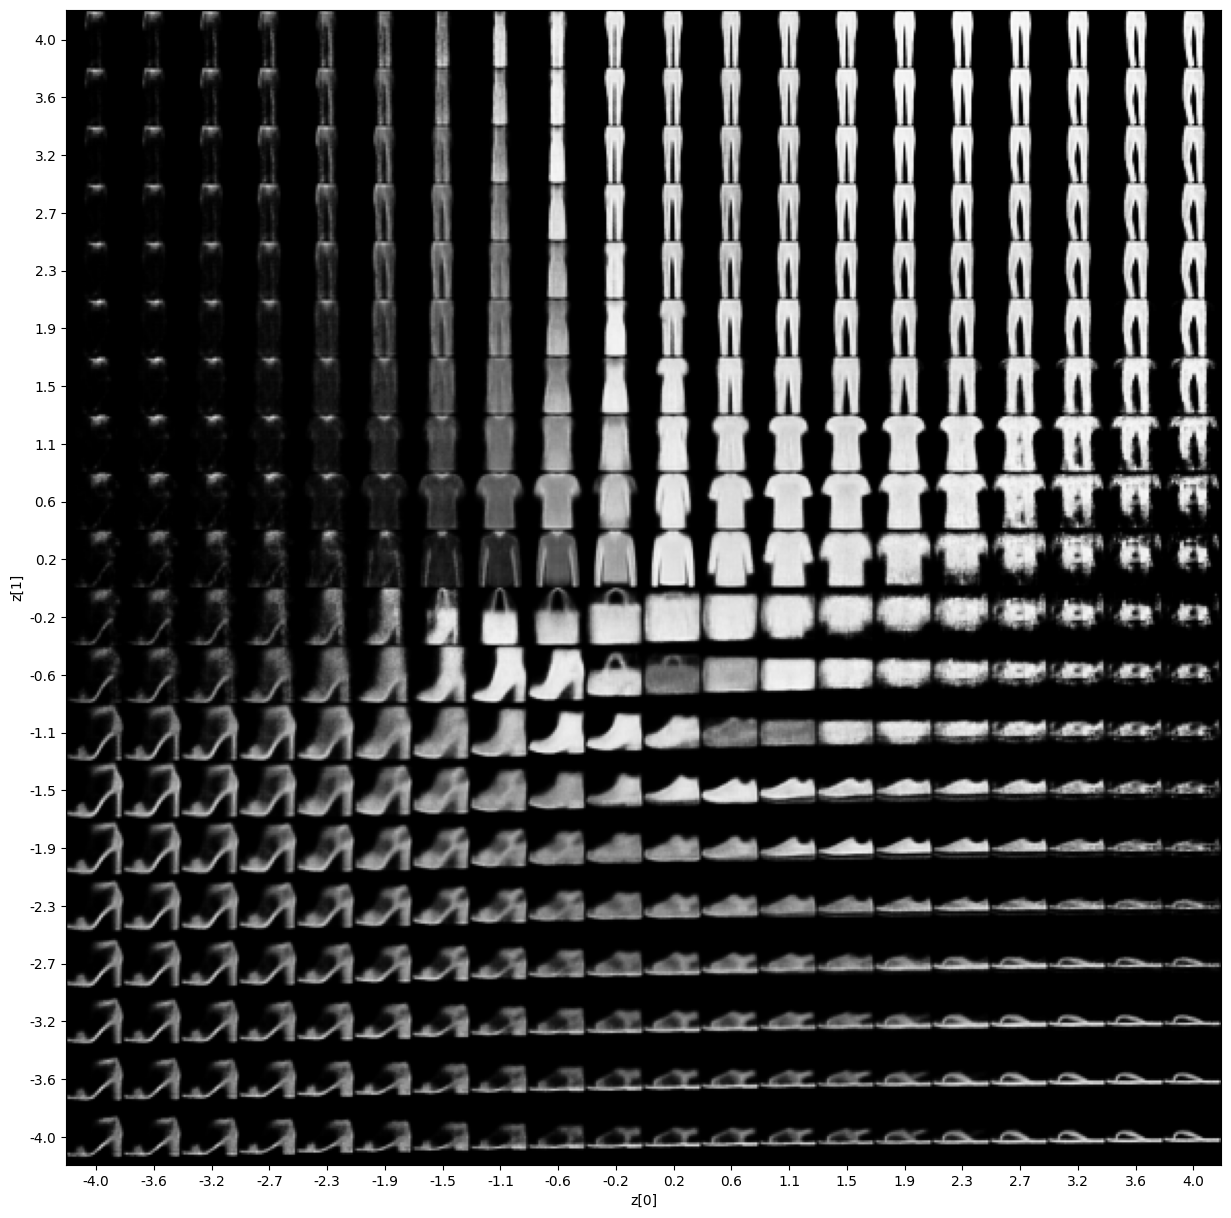

In [18]:
# Plot training history
#TODO: YOUR CODE HERE
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=20, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 4.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

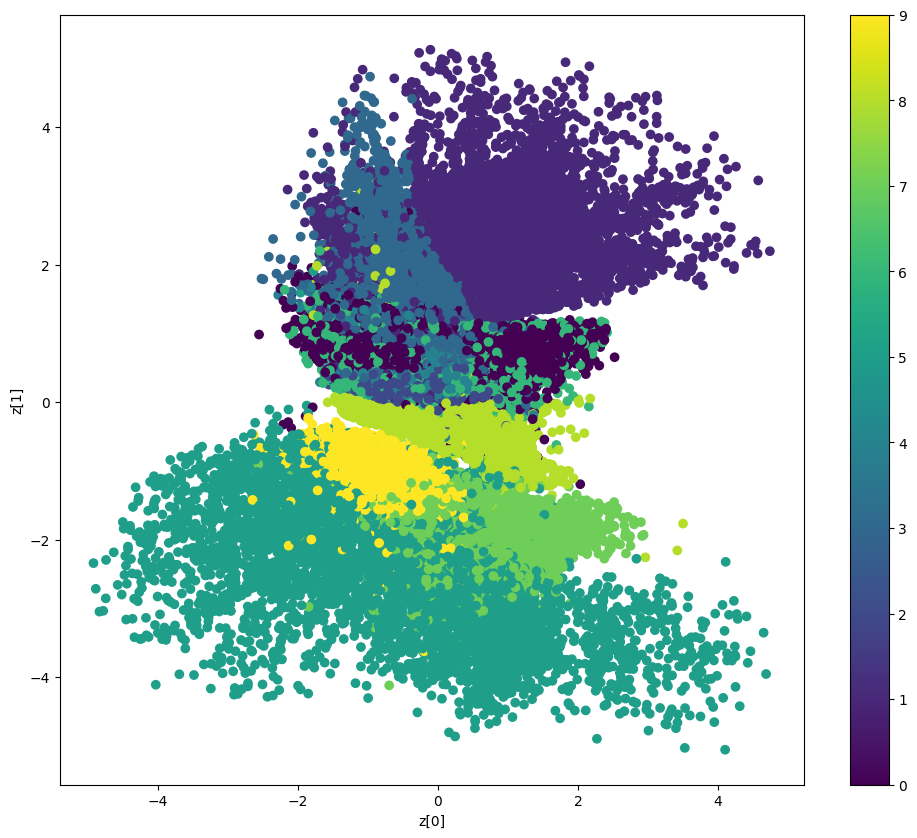

In [19]:
# Visualize the latent space
#TODO: YOUR CODE HERE


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

1/1 [==============================] - 0s 78ms/step


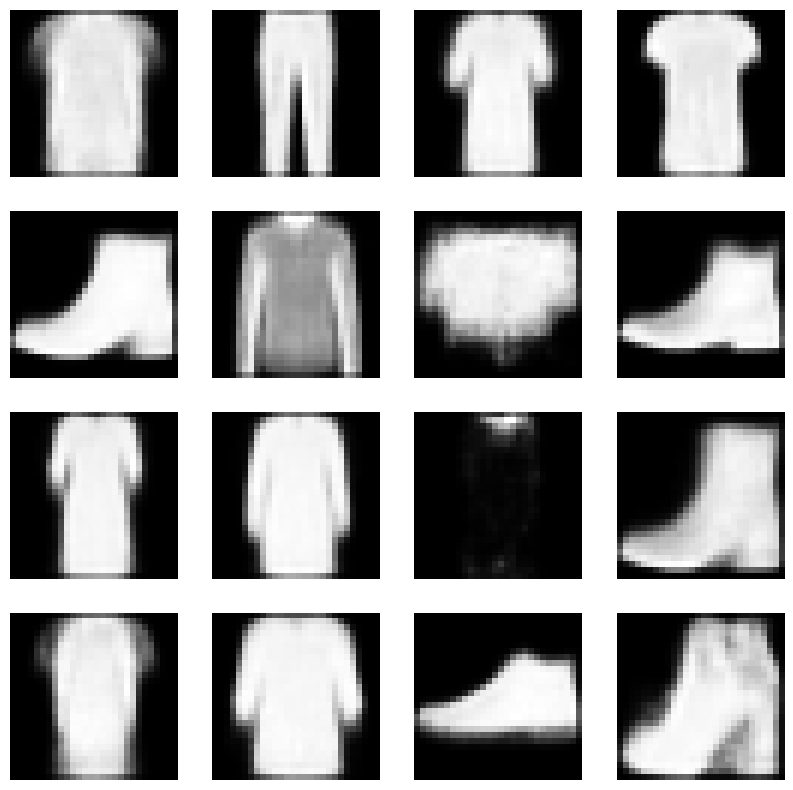

In [47]:
#####################################################
# Generate new images by sampling from latent space #
#####################################################

### YOUR CODE HERE
n_samples = 16 # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(n_samples, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

# Display the generated images
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap="Greys_r")
    plt.axis("off")
plt.show()


1/1 [==============================] - 0s 38ms/step


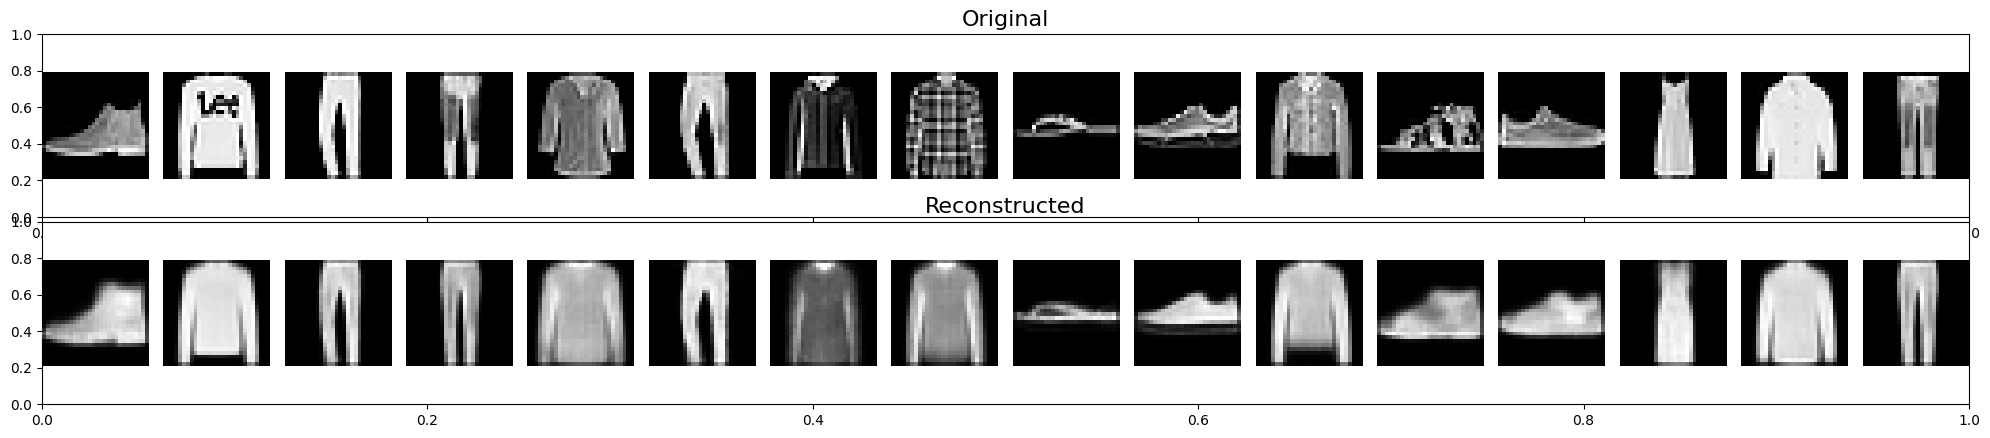

In [58]:
#############################################
# Compare original vs reconstructed images  #
#############################################

n = 16  # number of images to show

# Step 1: Prepare images with channel dimension
test_images = x_test[:n].astype("float32") 
test_images = test_images.reshape(-1, 28, 28, 1) # shape=(n,28,28,1)

# Step 2: Encode
z_mean, z_log_var, z = encoder.predict(test_images)

# Step 3: Sample latent vectors (stochastic)
epsilon = tf.random.normal(shape=z_mean.shape)
z_sample = z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Step 4: Decode
reconstructed_images = decoder.predict(z_sample)

# Step 5: Plot original vs reconstructed with numbered captions
plt.figure(figsize=(20, 4))

# Original images
plt.subplot(2, 1, 1)
plt.title("Original", fontsize=16)
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap="gray")
    plt.axis("off")
    ax.set_xlabel(str(i))  # подпись — номер

# Reconstructed images
plt.subplot(2, 1, 2)
plt.title("Reconstructed", fontsize=16)
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap="gray")
    plt.axis("off")
    ax.set_xlabel(str(i))  # подпись — номер

plt.tight_layout()
plt.show()